In [73]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

(-1, 1)

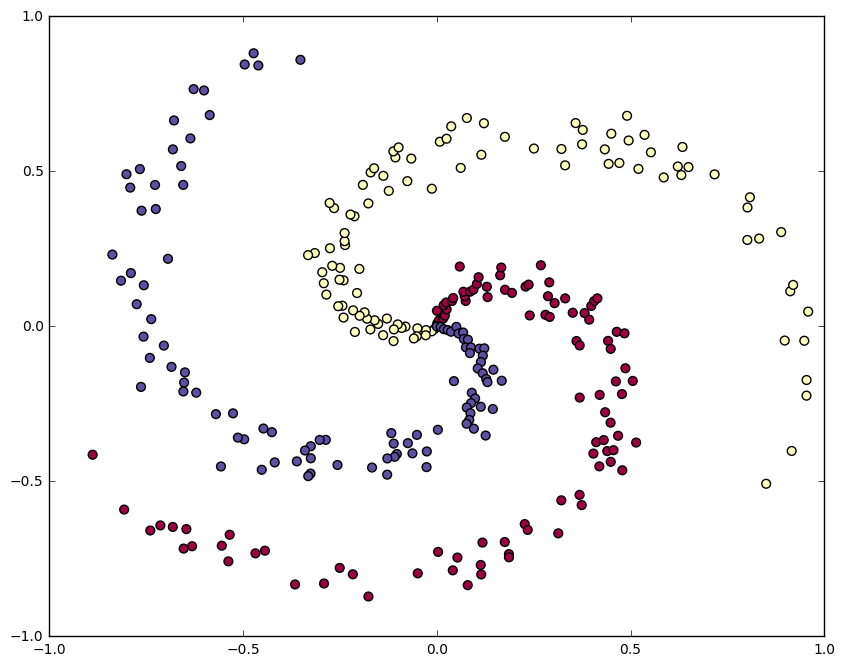

In [74]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
train_X = np.zeros((N*K,D))
train_y = np.zeros(N*K, dtype='uint8')
for j in xrange(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  train_X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  train_y[ix] = j
fig = plt.figure()
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [75]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [76]:
# Size definitions
num_examples = len(train_X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 3 # output layer dimensionality
nn_hdim = 200 # hiden layer dimensionality
nn_hdim2=300
# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 


In [77]:
# Our data vectors
X = T.matrix('X') # matrix of doubles
y = T.lvector('y') # vector of int64

In [78]:
(X * 2).eval({X : [[1,1],[2,2]] })

array([[ 2.,  2.],
       [ 4.,  4.]])

In [83]:
# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name='W1')
b1 = theano.shared(np.zeros(nn_hdim), name='b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_hdim2), name='W2')
b2 = theano.shared(np.zeros(nn_hdim2), name='b2')
W3 = theano.shared(np.random.randn(nn_hdim2, nn_output_dim), name='W3')
b3 = theano.shared(np.zeros(nn_output_dim), name='b3')

In [90]:


# Forward propagation
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
a2 = T.tanh(z2)
z3 = a2.dot(W3) + b3
y_hat = T.nnet.softmax(z3) # output probabilties

# The regularization term (optional)
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))+T.sum(T.sqr(W3))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(y_hat, axis=1)



In [91]:
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], y_hat)
calculate_loss = theano.function([X, y], loss)
predict = theano.function([X], prediction)

# Example call: Forward Propagation
forward_prop([[1,2]])


array([[  9.99998593e-01,   3.18019158e-13,   1.40727020e-06]])

In [92]:
# Easy: Let Theano calculate the derivatives for us!
dW3 = T.grad(loss, W3)
db3 = T.grad(loss, b3)
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

In [93]:
gradient_step = theano.function(
    [X, y],
    updates=((W3, W3 - epsilon * dW3),
             (W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b3, b3 - epsilon * db3),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [96]:
# This function learns parameters for the neural network and returns the model.
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(num_passes=20000, print_loss=False):
    
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_hdim2) / np.sqrt(nn_hdim2))
    b2.set_value(np.zeros(nn_hdim2))
    W3.set_value(np.random.randn(nn_hdim2,nn_output_dim)/ np.sqrt(nn_output_dim))
    b3.set_value(np.zeros(nn_output_dim))
    
    # Gradient descent. For each batch...
    for i in xrange(0, num_passes):
        # This will update our parameters W2, b2, W1 and b1!
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y))

Loss after iteration 0: 1.363188
Loss after iteration 1000: 0.106082
Loss after iteration 2000: 0.077339
Loss after iteration 3000: 0.065503
Loss after iteration 4000: 0.058651
Loss after iteration 5000: 0.054054
Loss after iteration 6000: 0.050702
Loss after iteration 7000: 0.048123
Loss after iteration 8000: 0.046062
Loss after iteration 9000: 0.044367
Loss after iteration 10000: 0.042942
Loss after iteration 11000: 0.041720
Loss after iteration 12000: 0.040659
Loss after iteration 13000: 0.039726
Loss after iteration 14000: 0.038901
Loss after iteration 15000: 0.038166
Loss after iteration 16000: 0.037509
Loss after iteration 17000: 0.036917
Loss after iteration 18000: 0.036383
Loss after iteration 19000: 0.035897


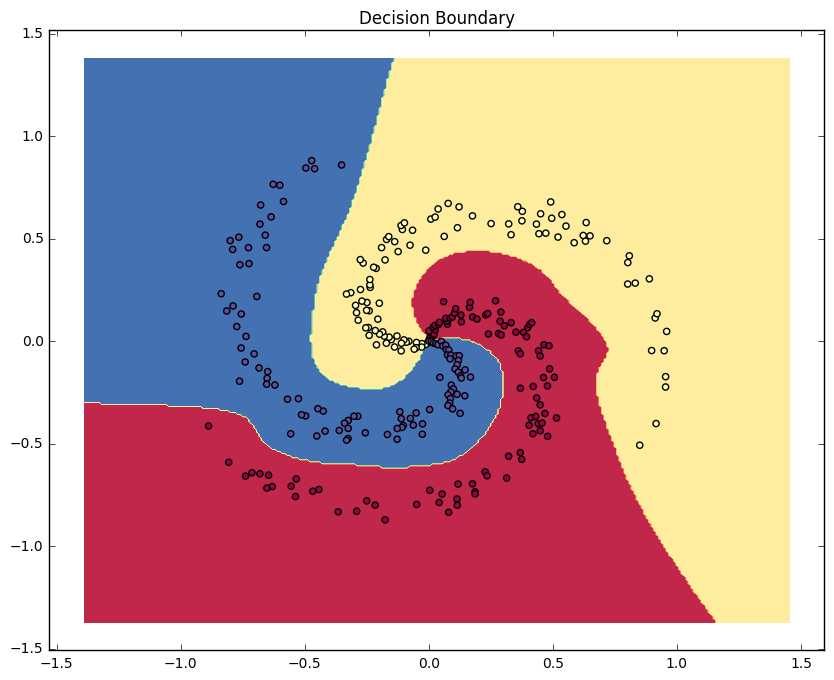

In [100]:
# Build a model with a 3-dimensional hidden layer
build_model(print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary")


In [101]:
ans=predict(train_X)

In [102]:
print 'training accuracy: %.2f' % (np.mean(ans == train_y))

training accuracy: 0.99
